# 0.0 Imports

In [76]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import umap.umap_ as umap

from IPython.display     import HTML
from matplotlib          import pyplot  as plt
from sklearn             import cluster as c
from sklearn             import metrics as m
from sklearn             import preprocessing as pp
from plotly              import express as px
from yellowbrick.cluster import KElbowVisualizer
from pylab               import rcParams
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1. Helper Functions

In [38]:
def jupyter_settings():
    %matplotlib inline
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
        
jupyter_settings()

## 0.2. Load dataset

In [39]:
# load data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')

df_raw

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,7-Dec-17,0.85,12680.0,France,NaN
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,7-Dec-17,2.10,12680.0,France,NaN
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,7-Dec-17,4.15,12680.0,France,NaN
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,7-Dec-17,4.15,12680.0,France,NaN


In [40]:
# drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

# 1.0 Data description

In [41]:
df1 = df_raw.copy()

## 1.1 Rename columuns

In [42]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data types

In [43]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.3 Check NA

In [44]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.4 Replace NA

In [45]:
# remove na
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}'.format(1-( df1.shape[0] / df_raw.shape[0])))

Removed data: 0.25


In [46]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.5 Change dtypes

In [47]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [48]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## <font color='red'> 1.6 Descriptive statistics </font>

# 2.0 Feature engineering 

In [49]:
df2 = df1.copy()

## 2.1 Feature creation

In [50]:
# data reference
df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1 ).drop_duplicates(ignore_index=True)

# Gross Revenue - quantity * price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']


# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')


# Recency - Last day of purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')


# Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')


# Avg Ticket
df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')


df_ref=df_ref.rename(columns={'invoice_no':'total_invoices'})

# <font color='red'> 3.0 Variable filtering </font>

In [51]:
df3 = df_ref.copy()

# <font color='red'> 4.0 EDA (Exploratory Data Analysis) </font>

In [52]:
df4 = df3.copy()

# 5.0 Data preparation 

In [78]:
df5 = df4.copy()

ssgross = pp.RobustScaler()
ssrecency = pp.RobustScaler()
ssinvoice = pp.RobustScaler()
ssavg = pp.RobustScaler()

df5['gross_revenue'] = ssgross.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ssrecency.fit_transform(df5[['recency_days']])
df5['total_invoices'] = ssinvoice.fit_transform(df5[['total_invoices']])
df5['avg_ticket'] = ssavg.fit_transform(df5[['avg_ticket']])

# <font color='red'> 6.0 Feature selection </font>

In [79]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

In [80]:
X = df6.drop(columns=['customer_id'])

In [84]:
clusters = [2, 3, 4, 5, 6,7,8,9,10]

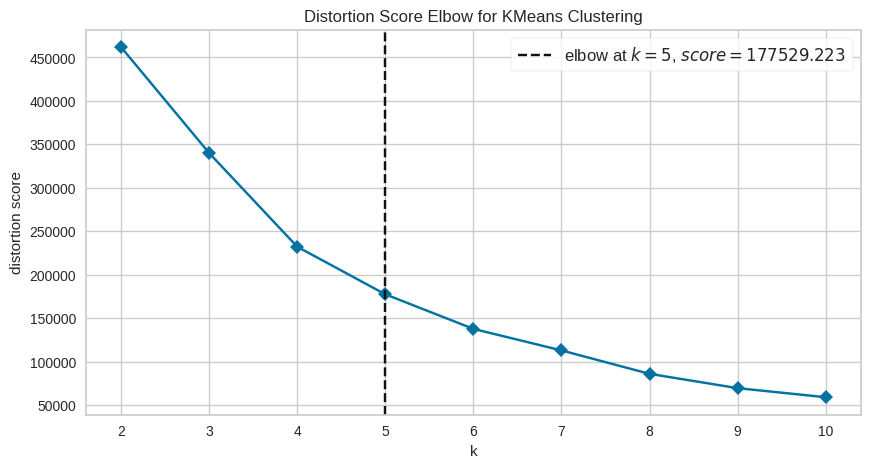

In [85]:
kmeans = KElbowVisualizer(c.KMeans(n_init='auto'),k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

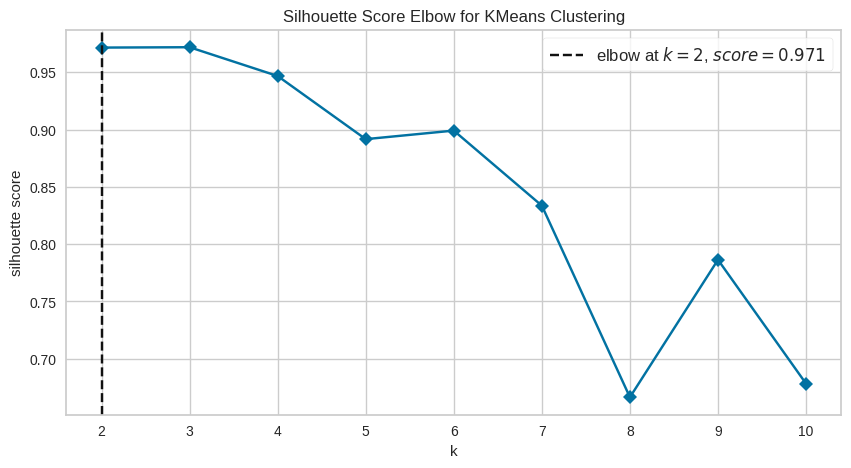

In [86]:
kmeans = KElbowVisualizer(c.KMeans(n_init='auto'), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show();

#  8.0 Model training 

## 8.1 K-Means

In [87]:
# model definition
k = 10
kmeans = c.KMeans(n_clusters=k,n_init='auto',random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.2 Cluster validation

In [88]:
## WSS (Within-cluster sum of square)
print('WSS value: {}'.format(kmeans.inertia_))

## SS (Silhouette Score 
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 59144.890640879086
SS value: 0.6822833777480055


# 9.0 Cluster analysis

In [96]:
df9 = df6.copy()
df9['cluster'] = labels

df9['gross_revenue'] = ssgross.inverse_transform(df9[['gross_revenue']])
df9['recency_days'] = ssrecency.inverse_transform(df9[['recency_days']])
df9['total_invoices'] = ssinvoice.inverse_transform(df9[['total_invoices']])
df9['avg_ticket'] = ssavg.inverse_transform(df9[['avg_ticket']])

## 9.1 Visualization inspection

In [63]:
# fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
# fig.show()

/home/soturno/.pyenv/versions/3.10.4/envs/pa05/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


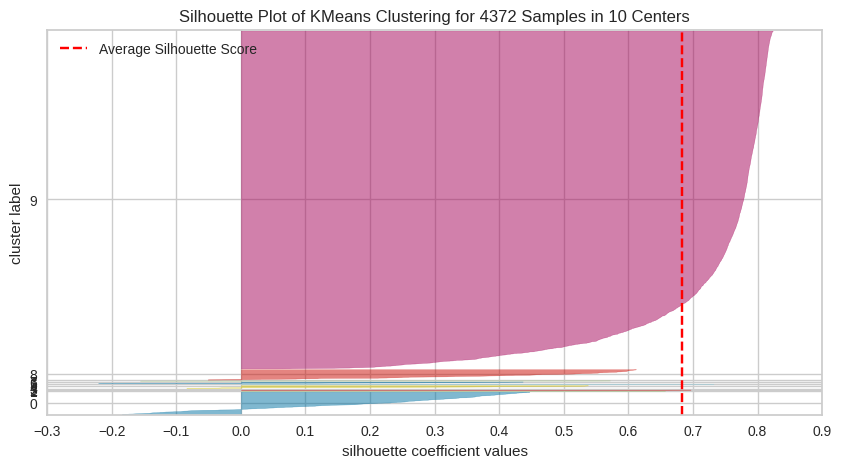

In [93]:
rcParams['figure.figsize'] = 10,5

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 UMAP

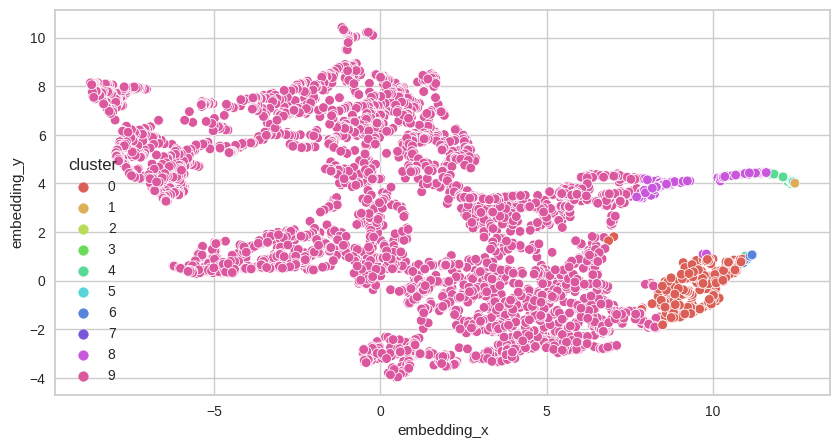

In [94]:
df_viz = df9.drop(columns='customer_id', axis=1)

reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                 data=df_viz);

## 9.3 Cluster profile

In [97]:
# Percentual of costumer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )
df_cluster['perc_customer']=df_cluster['perc_customer'].map('{:,.2f} %'.format)

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )
df_cluster=df_cluster.rename(columns={'gross_revenue':'avg_gross_revenue'})

# Gross revenue percentual
df_gross_perc = df9[['cluster', 'gross_revenue']].groupby('cluster').sum().reset_index()
df_cluster['gross_perc'] = 100*(df_cluster['avg_gross_revenue'] / df_cluster['avg_gross_revenue'].sum())
df_cluster['gross_perc']=df_cluster['gross_perc'].map('{:,.2f} %'.format)

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')
df_cluster['recency_days']=df_cluster['recency_days'].map('{:,.2f}'.format)
df_cluster=df_cluster.rename(columns={'recency_days':'avg_recency_days'})

# Avg invoice_no
df_invoice_no = df9[['total_invoices', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, how='inner', on='cluster')
df_cluster['total_invoices']=df_cluster['total_invoices'].map('{:,.2f}'.format)
df_cluster=df_cluster.rename(columns={'total_invoices':'avg_invoices'})

df_cluster=df_cluster.sort_values(['avg_gross_revenue'],ascending=False).reset_index(drop=True)

df_cluster['avg_gross_revenue']=df_cluster['avg_gross_revenue'].map('$ {:,.2f}'.format)


df_cluster.loc[0:0,'cluster'] = 0
df_cluster.loc[1:1,'cluster'] = 1
df_cluster.loc[2:2,'cluster'] = 2

rows=df_cluster.shape[0:1]
rows=int(rows[0])

if rows>3:
        df_cluster.loc[3:3,'cluster'] = 3
        df_cluster.loc[4:4,'cluster'] = 4
        df_cluster.loc[5:5,'cluster'] = 5
        df_cluster.loc[6:6,'cluster'] = 6
        df_cluster.loc[7:7,'cluster'] = 7
        df_cluster.loc[8:8,'cluster'] = 8
        df_cluster.loc[9:9,'cluster'] = 9
        df_cluster.loc[10:10,'cluster'] = 10
else:
    None

df_cluster

,cluster,customer_id,perc_customer,avg_gross_revenue,gross_perc,avg_recency_days,avg_invoices
0,0,3,0.07 %,"$ 241,136.56",73.03 %,3.00,64.67
1,1,19,0.43 %,"$ 62,712.53",18.99 %,6.95,81.63
2,2,4,0.09 %,"$ 10,677.88",3.23 %,84.75,2.75
3,3,258,5.90 %,"$ 8,523.97",2.58 %,15.12,22.66
4,4,30,0.69 %,"$ 6,328.08",1.92 %,134.10,5.77
5,5,2,0.05 %,"$ 3,478.50",1.05 %,99.00,1.00
6,6,120,2.74 %,"$ 1,767.67",0.54 %,119.42,3.17
7,7,3932,89.94 %,$ 951.66,0.29 %,95.80,3.57
8,8,3,0.07 %,"$ -1,110.12",-0.34 %,208.33,1.00
9,9,1,0.02 %,"$ -4,287.63",-1.30 %,144.00,1.00


In [98]:
print("Cluster 0 - Insider Candidate")
print(f"Number of customers: {df_cluster.iloc[0]['customer_id'].astype(int)}")
print(f"Average recency: {df_cluster.iloc[0]['avg_recency_days']}")
print(f"Purchases on average: {df_cluster.iloc[0]['avg_invoices']}")
print(f"Average gross revenue: {df_cluster.iloc[0]['avg_gross_revenue']}")

print('\n')

print("Cluster 1 ")
print(f"Number of customers: {df_cluster.iloc[1]['customer_id'].astype(int)}")
print(f"Average recency: {df_cluster.iloc[1]['avg_recency_days']}")
print(f"Purchases on average: {df_cluster.iloc[1]['avg_invoices']}")
print(f"Average gross revenue: {df_cluster.iloc[1]['avg_gross_revenue']}")

print('\n')

print("Cluster 2 ")
print(f"Number of customers: {df_cluster.iloc[2]['customer_id'].astype(int)}")
print(f"Average recency: {df_cluster.iloc[2]['avg_recency_days']}")
print(f"Purchases on average: {df_cluster.iloc[2]['avg_invoices']}")
print(f"Average gross revenue: {df_cluster.iloc[2]['avg_gross_revenue']}")

print('\n')

print("Cluster 3 ")
print(f"Number of customers: {df_cluster.iloc[3]['customer_id'].astype(int)}")
print(f"Average recency: {df_cluster.iloc[3]['avg_recency_days']}")
print(f"Purchases on average: {df_cluster.iloc[3]['avg_invoices']}")
print(f"Average gross revenue: {df_cluster.iloc[3]['avg_gross_revenue']}")

Cluster 0 - Insider Candidate
Number of customers: 3
Average recency: 3.00
Purchases on average: 64.67
Average gross revenue: $ 241,136.56


Cluster 1 
Number of customers: 19
Average recency: 6.95
Purchases on average: 81.63
Average gross revenue: $ 62,712.53


Cluster 2 
Number of customers: 4
Average recency: 84.75
Purchases on average: 2.75
Average gross revenue: $ 10,677.88


Cluster 3 
Number of customers: 258
Average recency: 15.12
Purchases on average: 22.66
Average gross revenue: $ 8,523.97


# <font color='red'> 10.0. Deploy To Production </font>